 First, let's setup all of this...

In [1]:
from pathlib import Path
import spotipy
import json
from pprint import pprint
import dill
import seaborn as sns
sns.set_style('whitegrid')

# import modin as pd
import pandas as pd
pd.set_option('max_columns', None)
from typing import Dict, List, Union

from copy import deepcopy

# User configuration file, json with specifics key
credential_fp = Path(r'private/spotify_credential.json')

# List of interesting scopes
scope = ' '.join([
    'user-library-read',
    'user-top-read',
])


In [2]:

df_toptracks = pd.read_pickle(Path(r'private/toptracks.pickle'))


In [3]:
with pd.option_context('display.max_rows', None):
    pprint(df_toptracks.iloc[0,:])

available_markets                            [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...
disc_number                                                                                  1
duration_ms                                                                             222166
explicit                                                                                 False
href                                         https://api.spotify.com/v1/tracks/5qsFOopazL2H...
id                                                                      5qsFOopazL2HXDtpotj0mz
is_local                                                                                 False
name                                                                              hypnic jerks
popularity                                                                                  38
preview_url                                  https://p.scdn.co/mp3-preview/6d6466538bfe65f1...
track_number                                      

 Let's retrieve the most useful column for our analysis like:
 * related to music features
 * to classify it (name, etc...)
 * release date (could be related to a specific era)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f418454de90>,
      dtype=object)

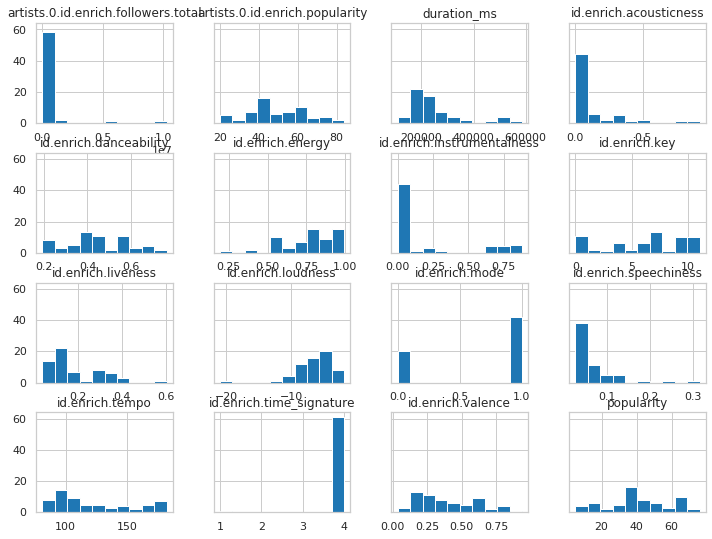

In [4]:

df = df_toptracks[[
    'id',
    'name',
    'artists.0.id.enrich.name',
    'album.release_date',
    'artists.0.id.enrich.genres',
    'popularity',
    'duration_ms',
    'artists.0.id.enrich.popularity',
    'artists.0.id.enrich.followers.total',
    'id.enrich.danceability',
    'id.enrich.energy',
    'id.enrich.key',
    'id.enrich.loudness',
    'id.enrich.mode',
    'id.enrich.speechiness',
    'id.enrich.acousticness',
    'id.enrich.instrumentalness',
    'id.enrich.liveness',
    'id.enrich.valence',
    'id.enrich.tempo',
    'id.enrich.time_signature',
]]

df_plot:pd.DataFrame = df.drop([
    'id',
    'name',
    'artists.0.id.enrich.name',
    'album.release_date',
    'artists.0.id.enrich.genres'
], axis=1)

sns.set_context('notebook')
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)

df_plot.hist(sharey=True)


 We will try a clustering algorithm and use the "genre" feature to check if
 the clustering succeedded or is failing totally.
 As such we will cluster with T-SNE and then do a deeper analysis of the
 "genre" feature:
 https://spotipy.readthedocs.io/en/2.9.0/#spotipy.client.Spotify.recommendation_genre_seeds
 * how many unique genre there is
 * how many unique combination of genre there is
 * what is the distribution of genre and same for its combination
 * distribution of the number of genre per sample

In [5]:

from sklearn.manifold import TSNE

tsne_pos = TSNE().fit_transform(df.drop([
    'id',
    'name',
    'artists.0.id.enrich.name',
    'album.release_date',
    'artists.0.id.enrich.genres',
    'popularity',
    'duration_ms',
    'artists.0.id.enrich.popularity',
    'artists.0.id.enrich.followers.total',
], axis=1))

df[['tsne_posx', 'tsne_posy']] = pd.DataFrame(tsne_pos)


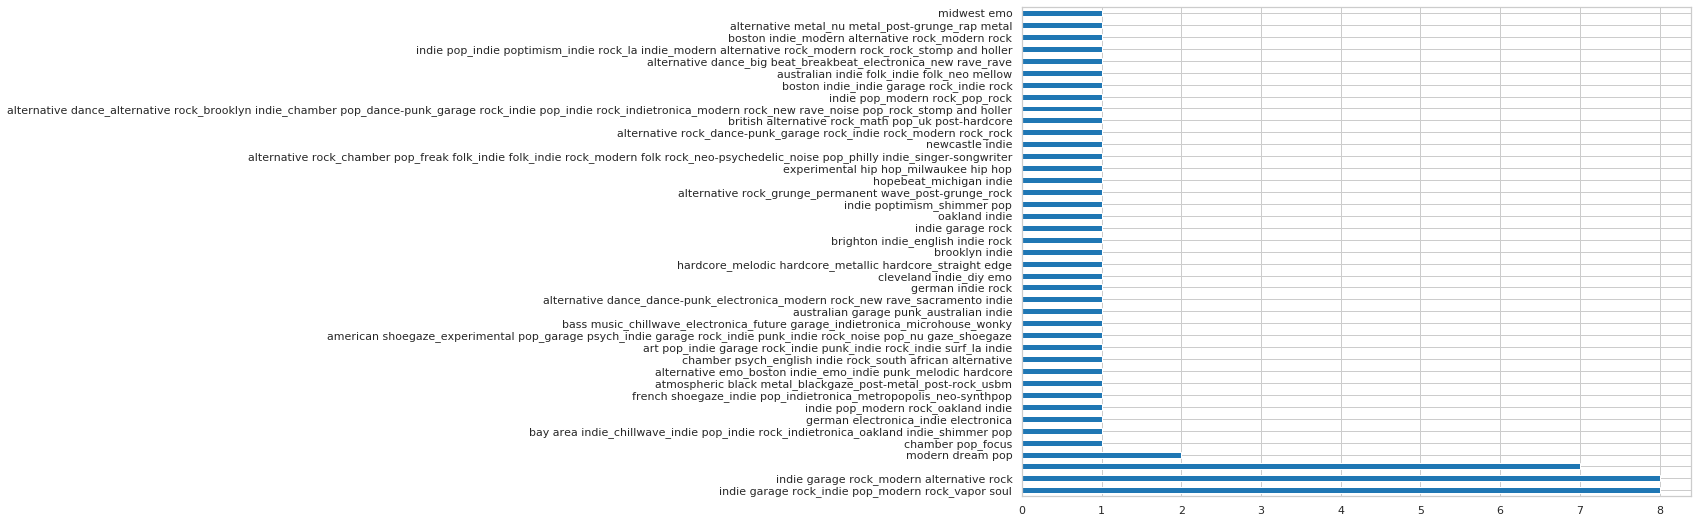

In [9]:

# analysis of combination
df['genre'] = df['artists.0.id.enrich.genres'].map(lambda x: '_'.join(x))
df.genre.value_counts().plot(kind='barh')

# analysis per element
# multi-label binarizer to apply first, column length = number of unique genre
from sklearn.preprocessing import MultiLabelBinarizer
genre_bin = MultiLabelBinarizer().fit_transform(
    df['artists.0.id.enrich.genres']
)



In [39]:
# multi-label binarizer to apply first, column length = number of unique genre
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_bin = mlb.fit_transform(
    df['artists.0.id.enrich.genres']
)
df_genre = pd.DataFrame(genre_bin, columns=mlb.classes_, index=df.index)\
                .add_prefix('genre_')
df:pd.DataFrame = pd.concat([df,df_genre],axis=1)


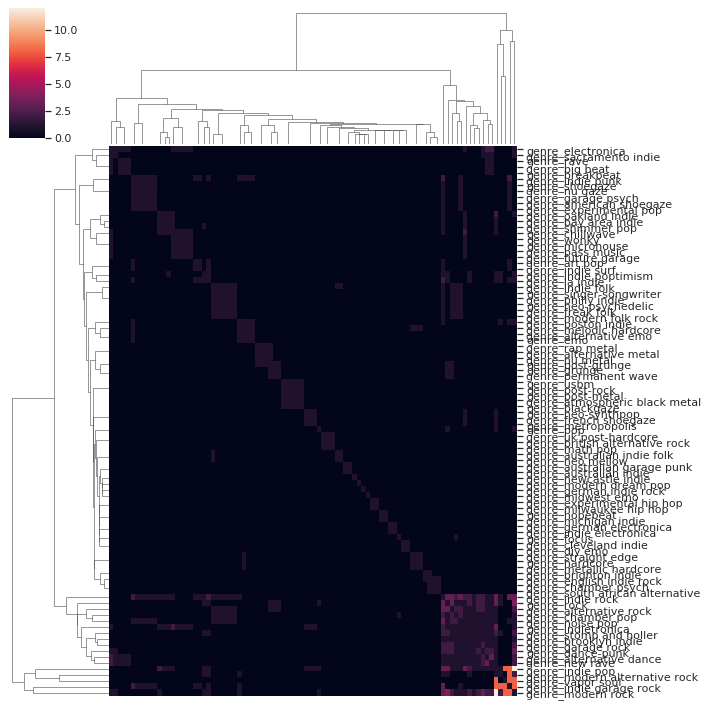

In [62]:

df_genre_corr = df_genre.corr(
    method = lambda x, y: sum([X and Y for X,Y in zip(x,y)])
)
g = sns.clustermap(df_genre_corr,
                    method='complete', 
                    xticklabels=False,
                    yticklabels=True)


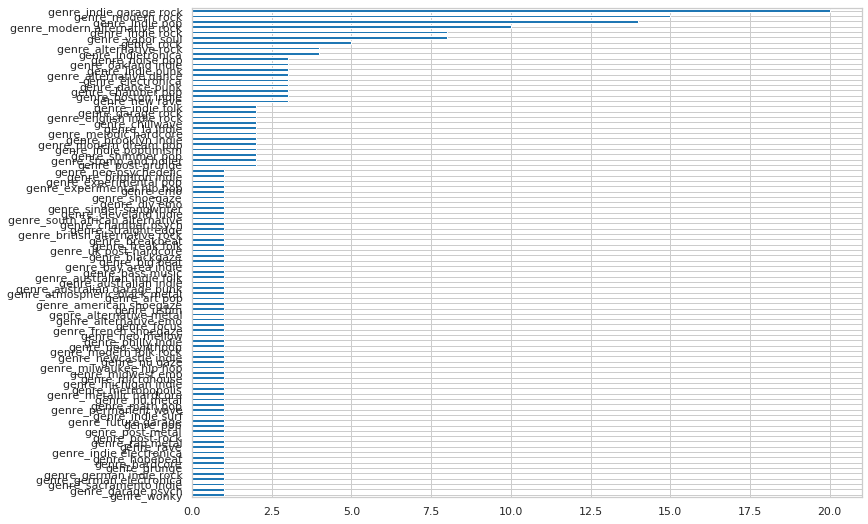

In [75]:
df_genre.sum().sort_values().plot(kind='barh')


In [82]:
import numpy as np


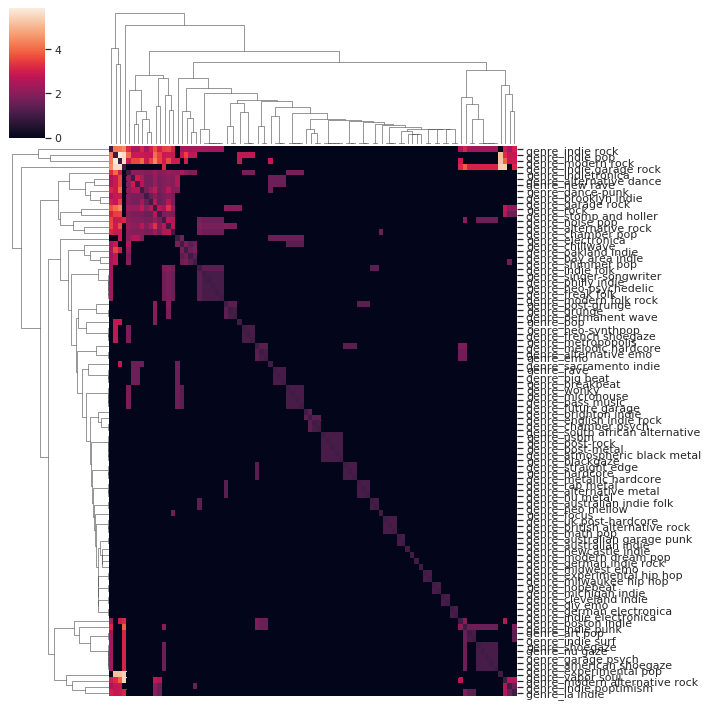

In [84]:
df_genre_corr_rel = df_genre.corr(
    method = lambda x, y: np.log(sum([X and Y for X,Y in zip(x,y)]) * (sum(x)+sum(y)) + 1)
)

g_rel = sns.clustermap(df_genre_corr_rel,
                    method='complete', 
                    xticklabels=False,
                    yticklabels=True)
